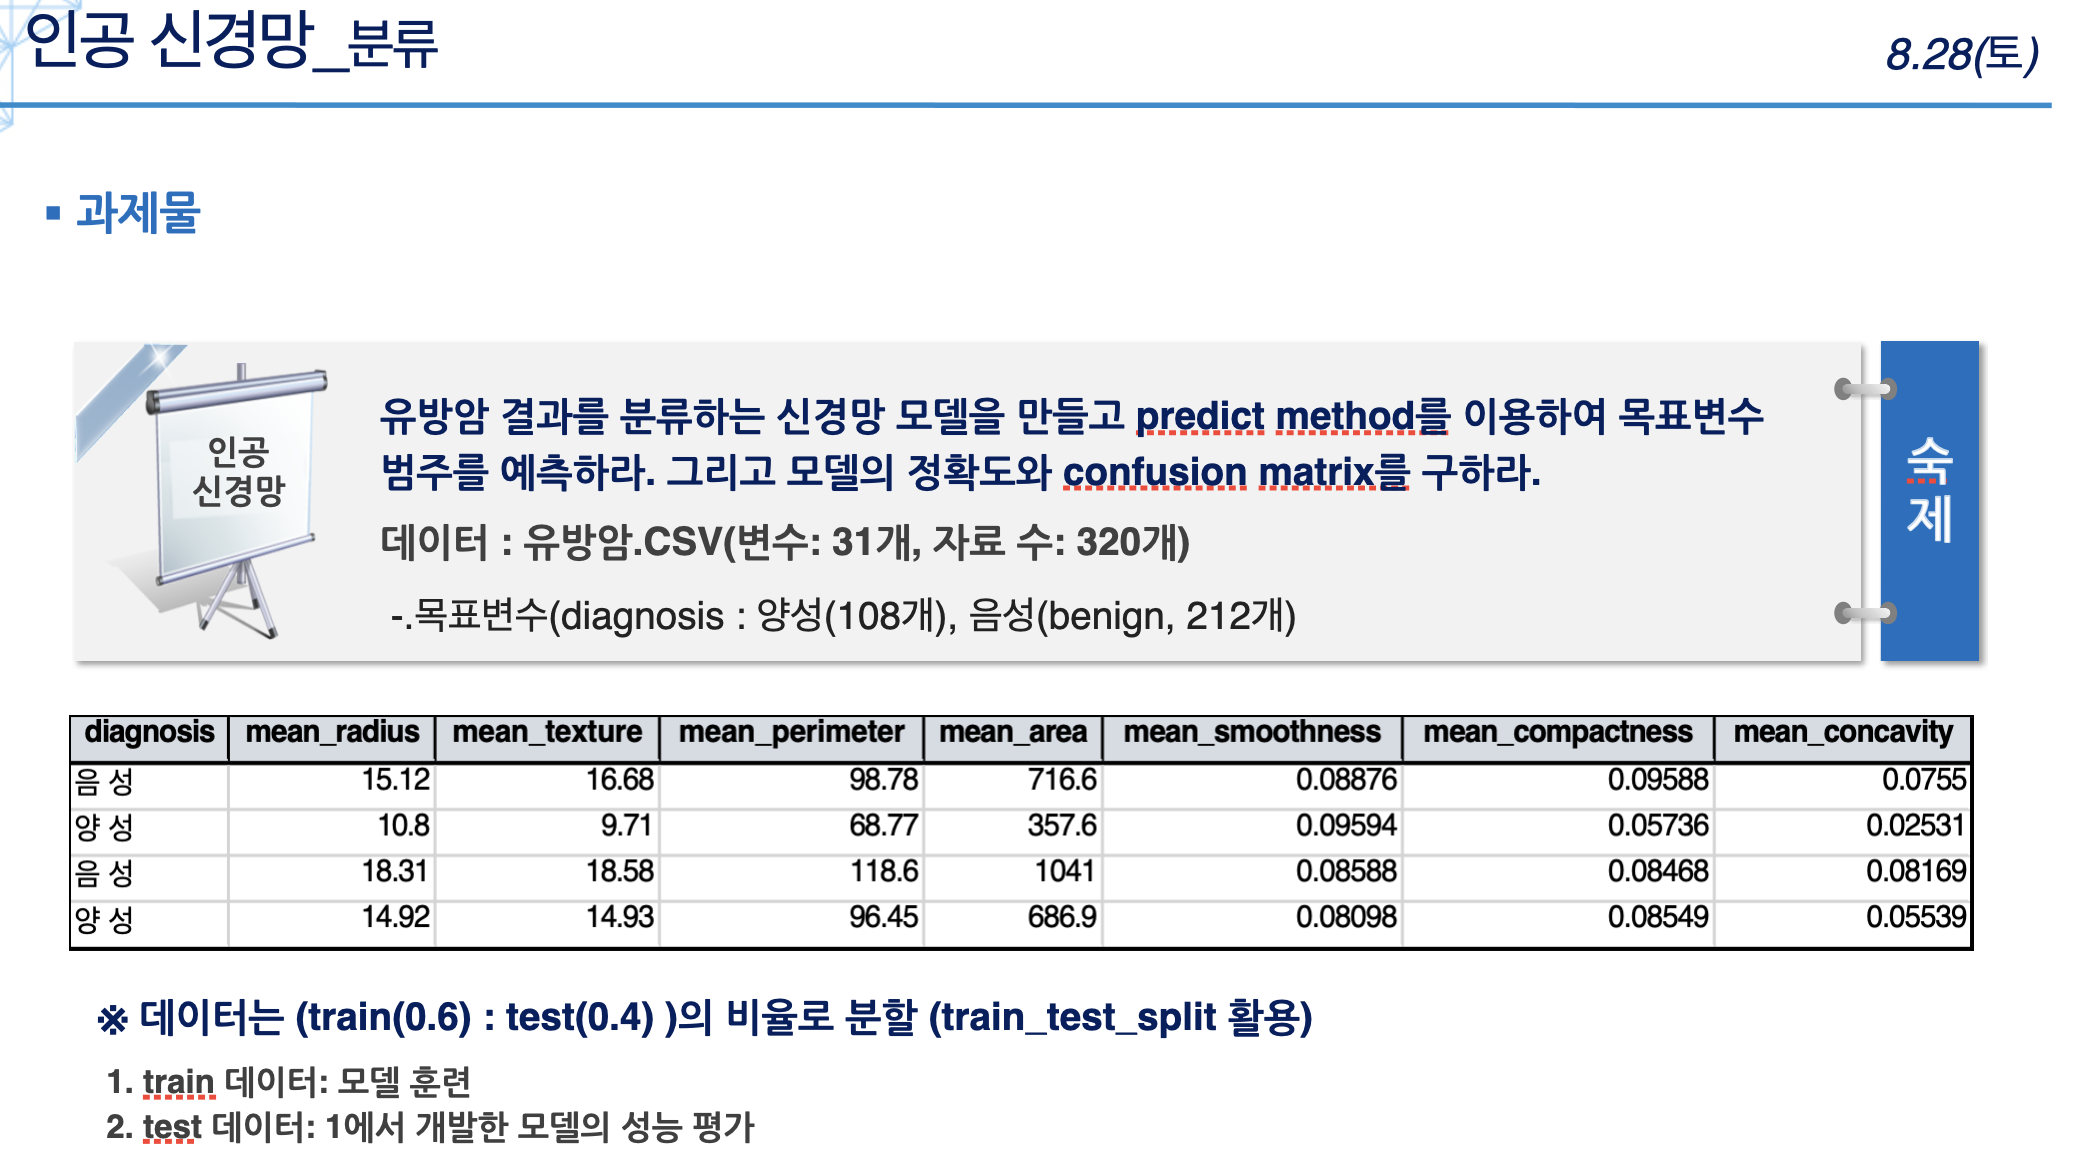

In [1]:
#데이터 구성 : Series, DataFrame
import pandas as pd
#데이터 시각화
import matplotlib.pyplot as plt
import matplotlib

#데이터 scaling
from sklearn.preprocessing import StandardScaler
#데이터 분할 : train, test
from sklearn.model_selection import train_test_split
#분류NN(MLPClassifier)
from sklearn.neural_network import MLPClassifier
#최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

#분류모델 평가 함수
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
matplotlib.rc('font', family='AppleGothic')
plt.rc('font',  family='AppleGothic')
plt.rcParams['axes.unicode_minus']=False

# 1.데이터 불러오기

In [2]:
# 데이터 구성 

df_raw=pd.read_csv('../data/유방암.csv',engine="python",encoding="CP949")
df_raw.head()

,diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,음성,15.12,16.68,98.78,716.6,0.08876,0.09588,0.07550,0.04079,0.1594,...,17.77,20.24,117.70,989.5,0.14910,0.3331,0.3327,0.12520,0.3415,0.09740
1,양성,10.80,9.71,68.77,357.6,0.09594,0.05736,0.02531,0.01698,0.1381,...,11.60,12.02,73.66,414.0,0.14360,0.1257,0.1047,0.04603,0.2090,0.07699
2,음성,18.31,18.58,118.60,1041.0,0.08588,0.08468,0.08169,0.05814,0.1621,...,21.31,26.36,139.20,1410.0,0.12340,0.2445,0.3538,0.15710,0.3206,0.06938
3,양성,14.92,14.93,96.45,686.9,0.08098,0.08549,0.05539,0.03221,0.1687,...,17.18,18.22,112.00,906.6,0.10650,0.2791,0.3151,0.11470,0.2688,0.08273
4,양성,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,...,13.62,15.54,87.40,577.0,0.09616,0.1147,0.1186,0.05366,0.2309,0.06915


# 2.데이터 전처리: object형 목표변수를 숫자형으로 변경 

In [3]:
df_raw.replace({'diagnosis': '양성'}, 1, inplace=True)
df_raw.replace({'diagnosis': '음성'}, 0, inplace=True)

df_raw_y=df_raw["diagnosis"]
df_raw_x=df_raw.drop("diagnosis",axis=1,inplace=False)

In [4]:
# 데이터 구성하기 - 데이터 분할
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x,df_raw_y,test_size=0.3,random_state=1234)
print("train data X size :{}".format(df_train_x.shape))
print("train data Y size :{}".format(df_train_y.shape))
print("test data X size :{}".format(df_test_x.shape))
print("test data Y size :{}".format(df_test_y.shape))

train data X size :(224, 30)
train data Y size :(224,)
test data X size :(96, 30)
test data Y size :(96,)


# 3. MLPClassifier 모델 생성 
## hyper parameter 튜닝 전 모델 정확도
Accuracy on trainning set : 0.625

Accuracy on test set : 0.750

'hidden_layer_sizes'=100, 
모델에 과소적합되어있으므로 hyper parameter 튜닝이 필요하다.

In [5]:
nn_uncustomized = MLPClassifier(random_state=1234)
#hidden_layer_size=(100,100) 변경 (은닉층 2개, 각 은닉층 노드 100개)
nn_uncustomized.fit(df_train_x, df_train_y)
#train 데이터 셋 정확도 
print("Accuracy on trainning set : {:.3f}".format(nn_uncustomized.score(df_train_x, df_train_y)))
#test 데이터 셋 정확도 ㅍ
print("Accuracy on test set : {:.3f}".format(nn_uncustomized.score(df_test_x, df_test_y)))

Accuracy on trainning set : 0.625
Accuracy on test set : 0.750


In [6]:
# 튜닝 전 모델 defalt 파라메터
nn_uncustomized.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1234,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

# 4-1. 모델 파라메터 영향 확인: 은닉층 크기(노드 개수) 

## 4-1-1. 은닉층 개수 1개일 경우, 은닉층 크기 (20~160)에 따른 accuracy 변화

은닉층 크기(노드개수)가 많아질수록 train, test 정확도 높아지는 경향성이 확인된다.

In [7]:
#train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
#hidden_layer_size:은닉층 변경(20, 40, 60, 80, 100, 120, 140, 160)
para_hidden = [20*hidden for hidden in range(1,9)]

for v_hidden in para_hidden:
    nn = MLPClassifier(hidden_layer_sizes = v_hidden, random_state = 1234)#1D (20,)(40,)
    nn.fit(df_train_x,df_train_y)
    train_accuracy.append(nn.score(df_train_x,df_train_y))
    test_accuracy.append(nn.score(df_test_x,df_test_y))
    
#데이터 테이블로 저장
df_accuracy_hidden=pd.DataFrame()
df_accuracy_hidden["HiddenLayer"]=para_hidden
df_accuracy_hidden["TrainAccuracy"]=train_accuracy
df_accuracy_hidden["TestAccuracy"]=test_accuracy

/Users/dasol/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [8]:
#은닉층별 정확도 테이블 1D
df_accuracy_hidden.round(3)

,HiddenLayer,TrainAccuracy,TestAccuracy
0,20,0.938,0.896
1,40,0.897,0.938
2,60,0.915,0.875
3,80,0.929,0.854
4,100,0.625,0.750
5,120,0.933,0.906
6,140,0.911,0.948
7,160,0.871,0.896


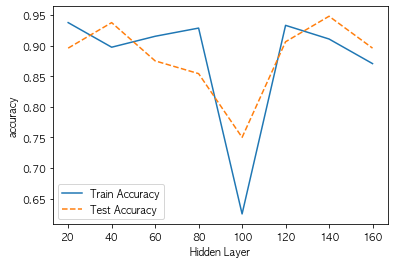

In [9]:
#모델 정확도 그래프 확인 1D
plt.plot(para_hidden,train_accuracy,linestyle="-",label="Train Accuracy")
plt.plot(para_hidden,test_accuracy,linestyle="--",label="Test Accuracy")
plt.ylabel("accuracy");plt.xlabel("Hidden Layer")
plt.legend()

## 4-1-2. 은닉층 개수 2개일 경우, 은닉층 크기 (20~160)에 따른 accuracy 변화

In [10]:
#모델 정확도 그래프 확인 2D
#train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
#hidden_layer_size:은닉층 변경(20, 40, 60, 80, 100, 120, 140, 160)
para_hidden = [20*hidden for hidden in range(1,9)]

for v_hidden in para_hidden:
    nn = MLPClassifier(hidden_layer_sizes = (v_hidden,v_hidden), random_state = 1234)#2D (20,20)(40,40)
    nn.fit(df_train_x,df_train_y)
    train_accuracy.append(nn.score(df_train_x,df_train_y))
    test_accuracy.append(nn.score(df_test_x,df_test_y))
    
#데이터 테이블로 저장
df_accuracy_hidden=pd.DataFrame()
df_accuracy_hidden["HiddenLayer"]=para_hidden
df_accuracy_hidden["TrainAccuracy"]=train_accuracy
df_accuracy_hidden["TestAccuracy"]=test_accuracy

#은닉층별 정확도 테이블 2D
df_accuracy_hidden.round(3)

,HiddenLayer,TrainAccuracy,TestAccuracy
0,20,0.942,0.875
1,40,0.701,0.604
2,60,0.888,0.844
3,80,0.933,0.875
4,100,0.911,0.844
5,120,0.893,0.885
6,140,0.915,0.885
7,160,0.875,0.917


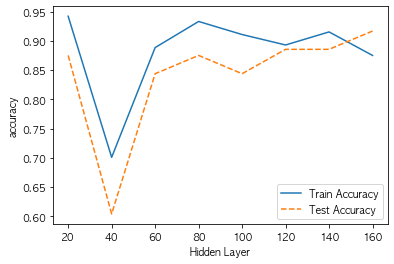

In [11]:
plt.plot(para_hidden,train_accuracy,linestyle="-",label="Train Accuracy")
plt.plot(para_hidden,test_accuracy,linestyle="--",label="Test Accuracy")
plt.ylabel("accuracy");plt.xlabel("Hidden Layer")
plt.legend()

# 4-2.모델 파라메터 영향 확인: 활성함수

relu함수의 경우 test 정확도가 train보다 높게 나오는 이상 현상 발생하며, 

train정확도가 급격히 낮아진다.

따라서 인공 신경망에서 필수로 적용해야하는 설명 변수의 Scale 차이 변환을 실행하기로 결정하였다.

In [12]:
#train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
#hidden_layer_size:은닉층 변경(20, 40, 60, 80, 100, 120, 140, 160)
para_funtion = ['logistic','tanh','relu']

for v_function in para_funtion:
    nn = MLPClassifier(activation= v_function, random_state = 1234)#1D (20,)(40,)
    nn.fit(df_train_x,df_train_y)
    train_accuracy.append(nn.score(df_train_x,df_train_y))
    test_accuracy.append(nn.score(df_test_x,df_test_y))
    
#데이터 테이블로 저장
df_accuracy_function=pd.DataFrame()
df_accuracy_function["ActivationFuntion"]=para_funtion
df_accuracy_function["TrainAccuracy"]=train_accuracy
df_accuracy_function["TestAccuracy"]=test_accuracy

In [13]:
df_accuracy_function.round(3)

,ActivationFuntion,TrainAccuracy,TestAccuracy
0,logistic,0.933,0.875
1,tanh,0.924,0.875
2,relu,0.625,0.750


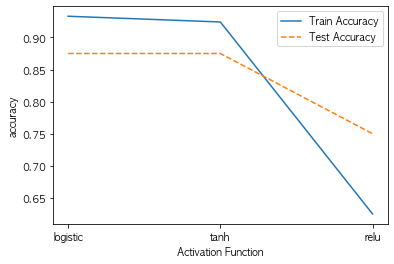

In [14]:
#모델 정확도 그래프 확인
plt.plot(para_funtion,train_accuracy,linestyle="-",label="Train Accuracy")
plt.plot(para_funtion,test_accuracy,linestyle="--",label="Test Accuracy")
plt.ylabel("accuracy");plt.xlabel("Activation Function")
plt.legend()

# 5. Scale변환
### 요약 통계량
설명 변수들의 평균과 표준편차 차이가 크므로 Scale 변환 필요성이 확인되었다.

In [35]:
df_raw.describe()

,diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
count,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,...,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,0.337500,15.709703,20.323250,103.050469,807.735937,0.099358,0.123252,0.122144,0.066977,0.186772,...,18.542406,27.225594,123.221625,1133.463438,0.137678,0.308713,0.352927,0.145487,0.305097,0.087156
std,0.473598,3.745788,4.150729,25.835984,391.969297,0.014249,0.057207,0.084822,0.041732,0.027485,...,5.182210,6.050052,35.960154,640.979627,0.023316,0.175225,0.214449,0.067292,0.069367,0.020076
min,0.000000,7.691000,9.710000,47.920000,170.400000,0.052630,0.026750,0.000000,0.000000,0.127400,...,8.678000,12.020000,54.490000,223.600000,0.085670,0.050360,0.000000,0.000000,0.156500,0.055040
25%,0.000000,13.050000,17.460000,84.845000,523.900000,0.090240,0.081132,0.052770,0.029537,0.166900,...,14.657500,23.275000,95.525000,653.525000,0.122675,0.180275,0.182950,0.090867,0.258700,0.073475
50%,0.000000,15.125000,20.215000,100.100000,713.050000,0.098570,0.115300,0.110850,0.065265,0.184650,...,17.730000,26.880000,118.850000,969.200000,0.138050,0.276950,0.339750,0.152700,0.295800,0.082640
75%,1.000000,18.520000,22.500000,121.550000,1075.250000,0.108050,0.155650,0.169550,0.091778,0.202700,...,22.420000,30.937500,148.850000,1538.500000,0.151200,0.405675,0.483675,0.197100,0.328125,0.097745
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.170000,0.291000,0.663800,0.207500


### Scale 변환 결과: 평균이 0,  표준편차가 1로 변환된 것을 알 수 있다.

In [37]:
#변수명 저장
v_feature_name = df_train_x.columns
#StandardScaler 적용
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_raw_x)
df_scaled = pd.DataFrame(df_scaled, columns=v_feature_name)
df_scaled.describe()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
count,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,...,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02
mean,2.532696e-16,-6.522560e-16,-2.844947e-16,7.320533e-17,1.131734e-15,-4.649059e-17,1.131040e-16,-1.651457e-16,4.066192e-16,8.829742e-16,...,1.644518e-16,1.130866e-15,3.129441e-16,-6.661338e-17,-1.204592e-15,1.346145e-16,-7.910339e-17,-1.644518e-16,1.713907e-16,1.817990e-16
std,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,...,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00,1.001566e+00
min,-2.144078e+00,-2.560965e+00,-2.137206e+00,-1.628531e+00,-3.284486e+00,-1.689536e+00,-1.442260e+00,-1.607458e+00,-2.163524e+00,-1.771699e+00,...,-1.906495e+00,-2.517236e+00,-1.914321e+00,-1.421712e+00,-2.234131e+00,-1.476710e+00,-1.648315e+00,-2.165421e+00,-2.145534e+00,-1.602209e+00
25%,-7.111638e-01,-6.908989e-01,-7.057591e-01,-7.252621e-01,-6.409206e-01,-7.374164e-01,-8.191610e-01,-8.985510e-01,-7.241279e-01,-7.283403e-01,...,-7.508361e-01,-6.540078e-01,-7.714095e-01,-7.499304e-01,-6.445040e-01,-7.341324e-01,-7.938634e-01,-8.129523e-01,-6.699070e-01,-6.825086e-01
50%,-1.563406e-01,-2.612060e-02,-1.143788e-01,-2.419430e-01,-5.541402e-02,-1.392174e-01,-1.333628e-01,-4.108234e-02,-7.731061e-02,-1.718356e-01,...,-1.570138e-01,-5.721191e-02,-1.217590e-01,-2.566707e-01,1.596124e-02,-1.815506e-01,-6.154336e-02,1.073604e-01,-1.342341e-01,-2.252776e-01
75%,7.514302e-01,5.252472e-01,7.171588e-01,6.835562e-01,6.109248e-01,5.672238e-01,5.597562e-01,5.952241e-01,5.804388e-01,5.608839e-01,...,7.494228e-01,6.144939e-01,7.138043e-01,6.328921e-01,5.808470e-01,5.542250e-01,6.106452e-01,7.682083e-01,3.324944e-01,5.282929e-01
max,3.315649e+00,4.574242e+00,3.312564e+00,4.326655e+00,4.501416e+00,3.889336e+00,3.597318e+00,3.221391e+00,4.271853e+00,4.842278e+00,...,3.381761e+00,3.694077e+00,3.564468e+00,4.876011e+00,3.647983e+00,4.282831e+00,3.816063e+00,2.165812e+00,5.179179e+00,6.003840e+00


## Scale 변환 이전 데이터로 학습한 모델의 정확도

In [40]:
nn_original = MLPClassifier(random_state=1234)
nn_original.fit(df_train_x,df_train_y)

#train 데이터 정확도
print("Accuracy on NN scale 이전 training set:{:.3f}".format(nn_original.score(df_train_x,df_train_y)))
#test 데이터 정확도
print("Accuracy on NN scaled 이전 test set:{:.3f}".format(nn_original.score(df_test_x,df_test_y)))

Accuracy on NN scale 이전 training set:0.625
Accuracy on NN scaled 이전 test set:0.750


# 6.Scale 변환된 데이터로 SVM 모델 생성


## 모델 정확도

scale을 적용한 데이터의 train 정확도는 0.996으로 scale변환 전 0.625보다 증가,

scale을 적용한 데이터의 test 정확도는 0.958 scale변환 전 0.750보다 증가하였다.

## Scale 변환된 데이터로 train, test 데이터 생성

In [38]:
#데이터분할
df_scaled_train_x, df_scaled_test_x, = train_test_split(df_scaled, test_size = 0.3, random_state=1234)
print("train data X szie {}".format(df_scaled_train_x.shape))
print("test data Y szie {}".format(df_scaled_test_x.shape))

train data X szie (224, 30)
test data Y szie (96, 30)


In [41]:
nn_scaled = MLPClassifier(random_state=1234)
nn_scaled.fit(df_scaled_train_x, df_train_y)
#train 데이터 정확도
print("Accuracy on NN scale 이후 training set:{:.3f}".format(nn_scaled.score(df_scaled_train_x,df_train_y)))
#test 데이터 정확도
print("Accuracy on NN scale 이후 test set:{:.3f}".format(nn_scaled.score(df_scaled_test_x,df_test_y)))

Accuracy on NN scale 이후 training set:0.996
Accuracy on NN scale 이후 test set:0.958


/Users/dasol/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [43]:
#데이터분할
df_scaled_train_x, df_scaled_test_x, = train_test_split(df_scaled, test_size = 0.3, random_state=1234)
print("train data X szie {}".format(df_scaled_train_x.shape))
print("test data Y szie {}".format(df_scaled_test_x.shape))

train data X szie (224, 30)
test data Y szie (96, 30)


# 7-1. 모델 파라메터 조정: 은닉층 개수 =>160선택
test 정확도가 특별히 높은 160 선택

In [59]:
#train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
#hidden_layer_size:은닉층 변경(20~240, by 30)
para_hidden = [20*hidden for hidden in range(1,11)]

for v_hidden in para_hidden:
    #nn = MLPClassifier(hidden_layer_sizes = v_hidden, random_state = 1234,max_iter=600)#1D (20,)(40,)
    nn = MLPClassifier(hidden_layer_sizes=(v_hidden, v_hidden), random_state = 1234)
    nn.fit(df_scaled_train_x,df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x,df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x,df_test_y))
    
#데이터 테이블로 저장
df_accuracy_hidden=pd.DataFrame()
df_accuracy_hidden["HiddenLayer"]=para_hidden
df_accuracy_hidden["TrainAccuracy"]=train_accuracy
df_accuracy_hidden["TestAccuracy"]=test_accuracy

/Users/dasol/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/dasol/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [45]:
df_accuracy_hidden.round(3)

,HiddenLayer,TrainAccuracy,TestAccuracy
0,20,0.991,0.938
1,40,1.000,0.958
2,60,1.000,0.938
3,80,1.000,0.948
4,100,1.000,0.958
5,120,1.000,0.958
6,140,1.000,0.938
7,160,1.000,0.969
8,180,1.000,0.958
9,200,1.000,0.969


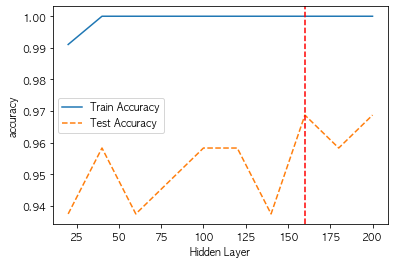

In [46]:
#모델 정확도 그래프 확인
plt.plot(para_hidden,train_accuracy,linestyle="-",label="Train Accuracy")
plt.plot(para_hidden,test_accuracy,linestyle="--",label="Test Accuracy")
plt.axvline(x=160, linestyle='--', c='r')
plt.ylabel("accuracy");plt.xlabel("Hidden Layer")
plt.legend()

In [47]:
#은닉층 지정(임의)
hidden_layer_sizes = 160

# 7-2.모델 파라메터 조정 : 활성함수 =>'relu'선택

relu 함수를 사용할 때 test 정확도가 97%까지 증가하므로 선택

In [49]:
#train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
#hidden_layer_size:은닉층 변경(20, 40, 60, 80, 100, 120, 140, 160)
para_funtion = ['logistic','tanh','relu']

for v_function in para_funtion:
    nn = MLPClassifier(activation= v_function, hidden_layer_sizes=(160, 160), random_state = 1234)#1D (20,)(40,)
    nn.fit(df_scaled_train_x,df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x,df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x,df_test_y))
    
#데이터 테이블로 저장
df_accuracy_function=pd.DataFrame()
df_accuracy_function["ActivationFuntion"]=para_funtion
df_accuracy_function["TrainAccuracy"]=train_accuracy
df_accuracy_function["TestAccuracy"]=test_accuracy

In [50]:
df_accuracy_function.round(3)

,ActivationFuntion,TrainAccuracy,TestAccuracy
0,logistic,0.991,0.948
1,tanh,1.000,0.948
2,relu,1.000,0.969


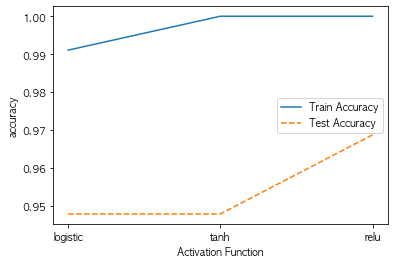

In [51]:
#모델 정확도 그래프 확인
plt.plot(para_funtion,train_accuracy,linestyle="-",label="Train Accuracy")
plt.plot(para_funtion,test_accuracy,linestyle="--",label="Test Accuracy")
plt.ylabel("accuracy");plt.xlabel("Activation Function")
plt.legend()

In [25]:
#Activation Function 지정(임의)
activation = 'relu'

# 7-3.모델 파라메터 조정 : 가중치 최적화 방식(solver) =>adam선택
train, test 정확도 차이가 가장 작고, test 정확도가 가장 높기 때문에 선택



In [56]:
#train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
#hidden_layer_size:은닉층 변경(20, 40, 60, 80, 100, 120, 140, 160)
para_solver = ['lbfgs','sgd','adam']

for v_solver in para_solver:
    nn = MLPClassifier(solver = v_solver, activation = 'relu', hidden_layer_sizes = (160,160), random_state = 1234, max_iter=600)
    nn.fit(df_scaled_train_x,df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x,df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x,df_test_y))
    
#데이터 테이블로 저장
df_accuracy_solver=pd.DataFrame()
df_accuracy_solver["Solver"]=para_solver
df_accuracy_solver["TrainAccuracy"]=train_accuracy
df_accuracy_solver["TestAccuracy"]=test_accuracy

In [57]:
df_accuracy_solver.round(3)

,Solver,TrainAccuracy,TestAccuracy
0,lbfgs,1.000,0.948
1,sgd,0.987,0.948
2,adam,1.000,0.969


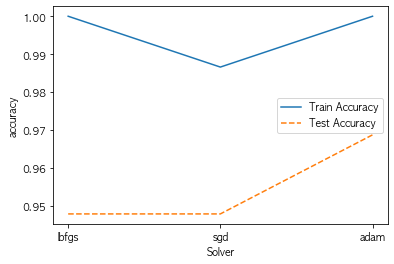

In [58]:
#모델 정확도 그래프 확인
plt.plot(para_solver,train_accuracy,linestyle="-",label="Train Accuracy")
plt.plot(para_solver,test_accuracy,linestyle="--",label="Test Accuracy")
plt.ylabel("accuracy");plt.xlabel("Solver")
plt.legend()

In [29]:
#Solver 지정(임의)
solver = "adam"

# 7-4.모델 파라메터 조정 : Mini Batch(train data를 등분하는 크기) =>70선택

미니배치 크기가 증가하면 test 정확도의 오차가 증가 경향성이 있기 때문에, 

test데이터 정확도가 높은 구간인 중 갑작스런 감소 현상 발생지점 이전인 70을 선택

In [70]:
#train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
#Mini Batch 변경
para_batch = [20*batch for batch in range(1,10)]

for v_batch in para_batch:
    nn = MLPClassifier(batch_size = v_batch, solver = "adam", activation = 'relu',
                       hidden_layer_sizes = (160,160), random_state = 1234)
    nn.fit(df_scaled_train_x,df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x,df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x,df_test_y))
    
#데이터 테이블로 저장
df_accuracy_batch=pd.DataFrame()
df_accuracy_batch["Mini Batch"]=para_batch
df_accuracy_batch["TrainAccuracy"]=train_accuracy
df_accuracy_batch["TestAccuracy"]=test_accuracy

In [71]:
df_accuracy_batch.round(3)

,Mini Batch,TrainAccuracy,TestAccuracy
0,20,1.0,0.969
1,40,1.0,0.969
2,60,1.0,0.979
3,80,1.0,0.979
4,100,1.0,0.948
5,120,1.0,0.979
6,140,1.0,0.979
7,160,1.0,0.979
8,180,1.0,0.969


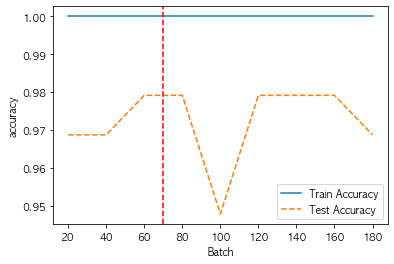

In [72]:
#모델 정확도 그래프 확인
plt.plot(para_batch,train_accuracy,linestyle="-",label="Train Accuracy")
plt.plot(para_batch,test_accuracy,linestyle="--",label="Test Accuracy")
plt.axvline(x=70, linestyle='--', c='r')

plt.ylabel("accuracy");plt.xlabel("Batch")
plt.legend()

# 8.최종 모델: 하이퍼 파라메터 ( 2D은닉층: (160, 160), 활성함수: Relu, solver: adam, mini_batch=70 )


# 최종 모델 평가






## 📌해석: accuracy

### NN(97.9%)>SVM(95.8%)>RandomForest(95.5%)>KNN(92.9%)>DecisionTree(90.6%)

NN 모델의 test 정확도는 97.9%으로 높지만, 

train 정확도가 100%이므로 train 데이터에 과적합되어있다.

이를 해결하고자 파라메터를 바꾸어보았으나, train 데이터에 과적합되는 현상을 아직 해결하지 못했다.


## 📌해석: recall
### NN(1.000)>SVM(0.909)>RandomForest(0.833)>DecisionTree(0.792)>KNN(0.750)

모델 중에서 가장 높다.

## 📌해석: f1-score
###  NN(0.960)>SVM(0.937)>DecisionTree(0.906)>RandomForest(0.833)>KNN(0.783)


모델 중에서 가장 높다. 이유는 NN모델의 recall이 높기 때문이다.


## 📌결론: 
### 유방암 데이터 특성
#### 1.유방암 양/음성 진단 데이터에서 양성은 전체 데이터의 24.3%로 불균형 데이터이다.
#### 2.또한 의학 분야이므로 유방암 양성을 음성으로 분류하는 경우 큰 문제가 생긴다.


### 모델 평가지표: accuracy, recall, f1-score
위의 2가지 데이터 특성에 의해서 

유방암 양성을 양성으로(TP) 음성을 음성으로(TN) 분류하는 개수뿐만아니라, 

유방암 양성을 음성으로 진단(FN)하는 개수 또한 중요하다.

따라서 모델 평가지표로 1순위: accuracy, 2순위: recall, 3순위: f1-score를 정하였다.


### ✔️유방암 진단을 위한 모델로 NN모델은 가장 적합하다.

이유: 

1. 총 24개의 양성 데이터를 모두 양성으로 맞췄다. (즉, recall 지표가 1이다.)


2. 총 5개 모델(NN, KNN,SVM,DecisionTree,RandomForest)의 결과를 비교해보면, 

    NN 모델은 accuracy에서 1위, recall에서 1위, f1-score에서 1위로

    성능이 좋기 때문이다. 

In [66]:
#최종모델
nn_final = MLPClassifier(hidden_layer_sizes = (160,160), activation = 'relu', solver ='adam',
                        batch_size = 70, random_state = 1234)
nn_final.fit(df_scaled_train_x, df_train_y)
y_pred = nn_final.predict(df_scaled_test_x)
#train 데이터 셋 정확도
print('Accuracy on training set: {:3f}'.format(nn_final.score(df_scaled_train_x, df_train_y)))
#test 데이터 셋 정확도
print('Accuracy on test set: {:3f}'.format(nn_final.score(df_scaled_test_x, df_test_y)))
#confusion matrix
print('Confusion matrix:\n{}'.format(confusion_matrix(df_test_y, y_pred)))
#목표변수의 빈도 불균형 : f1 score로 모델 평가
print(classification_report(df_test_y, y_pred, digits=3))

Accuracy on training set: 1.000000
Accuracy on test set: 0.979167
Confusion matrix:
[[70  2]
 [ 0 24]]
              precision    recall  f1-score   support

           0      1.000     0.972     0.986        72
           1      0.923     1.000     0.960        24

    accuracy                          0.979        96
   macro avg      0.962     0.986     0.973        96
weighted avg      0.981     0.979     0.979        96

